In [48]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import random
import os
import sys

from scipy.io import loadmat
import scipy.stats as st

from tqdm import tqdm

import torch.nn as nn
import torch

import plotly.express as px

import itertools

from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.metrics import pairwise_distances,r2_score,explained_variance_score

from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding, MDS
from sklearn.neighbors import LocalOutlierFactor

import statsmodels.api as sm

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

/home/robert/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# decoding lfads factors

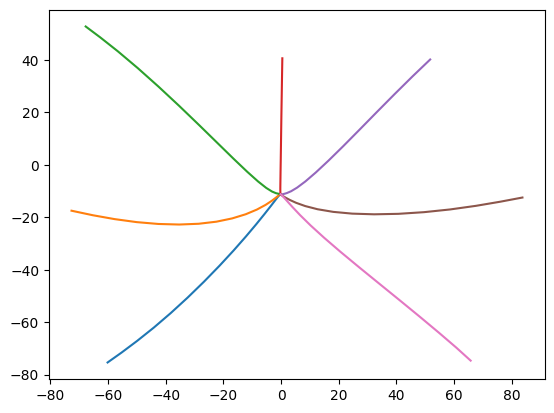

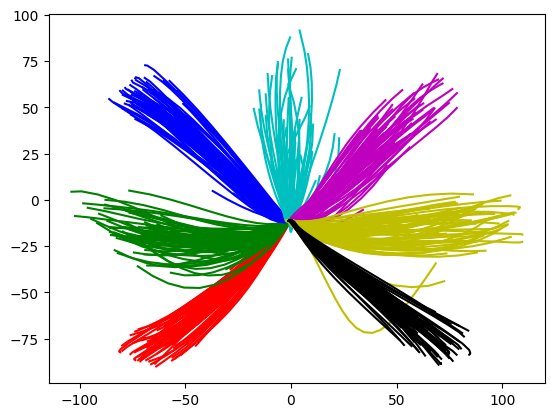

In [14]:
kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       

conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  

d = 5
K = kinematic_data[d]

plt.figure()
for cond in conditions:   
    meh = np.dstack([K[t]['kinematics'] for t in K.keys() if K[t]['condition']==cond]).mean(2)        
    plt.plot(meh[0,:],meh[1,:])
    

    
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])

In [15]:

K = kinematic_data[d]

X = []
Z = []
y = []
for tr in kinematic_data[d].keys():
    X.append(K[tr]['kinematics'][:,:-1])
    Z.append(K[tr]['lfads_factors'][:,:-1])
    y.append(K[tr]['condition'])
    
X = np.hstack(X)
Z = np.hstack(Z)
y = np.hstack(y)

X = X[:4,:] # they only took first four rows of kinematics
Z = np.vstack([Z,np.ones(Z.shape[1])])


out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
Lw = out[0].T

In [16]:


# loop over test trials
alpha = 1
dt = 20


for tr in kinematic_data[d].keys():
    
    #trial_emb = emb[:,trial_indexes==t] # get trial embedding
    trial_emb = K[tr]['lfads_factors'][:,:-1] # get trial embedding
    trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial

    
    trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])

    
    # first time point of embedding
    neural = trial_emb[:,0]

    # empty array for decoding predictions
    trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
    trial_pred[:] = np.nan

    trial_pred[:2,0] = trial_kinematics[:2,0]

    # predict velocity 
    z  = np.matmul(Lw,neural); # decode
    trial_pred[[2,3],0] = z[[2,3]]
    trial_pred[4,0] = 1


    # loop over each time point in trial
    for nt in range(1,trial_kinematics.shape[1]):

        neural = trial_emb[:,nt] # next point of embedding
        z  = np.matmul(Lw,neural); # decode

        trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

        trial_pred[[2,3],nt] = z[[2,3]]
        trial_pred[4,nt] = 1
    
    kinematic_data[d][tr]['lfads_decoded'] = trial_pred


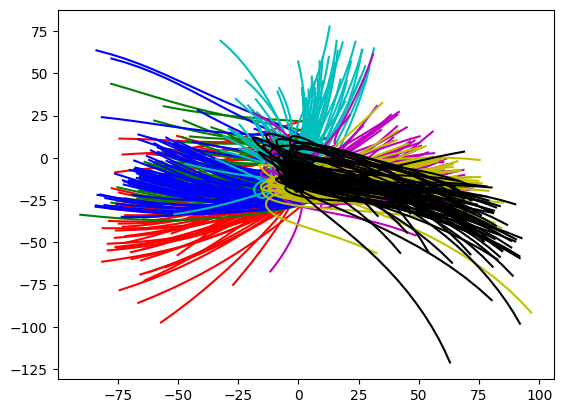

In [17]:
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['lfads_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
            

## analysing data without vectors or inner products

In [18]:

with open('./outputs/distance_matrices_and_embeddings_20ms_sc0.pkl', 'rb') as handle:
    data = pickle.load(handle)

distance_matrices = data[0]
embeddings = data[1]
timepoints = data[2]
labels = data[3]
trial_ids = data[4]
sample_inds = data[5]

conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  

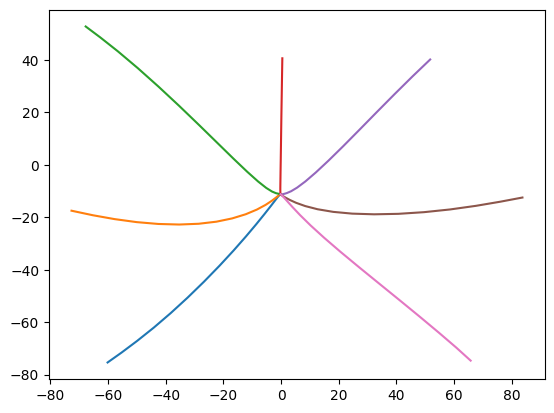

In [19]:
#kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       

conditions=['DownLeft','Left','UpLeft','Up','UpRight','Right','DownRight']  

K = kinematic_data[d]

plt.figure()

for cond in conditions:   
    meh = np.dstack([K[t]['kinematics'] for t in K.keys() if K[t]['condition']==cond]).mean(2)        
    plt.plot(meh[0,:],meh[1,:])


In [20]:
# use the saved trial ids to match the embeddings to the kinematics

unique_trial_ids = list(dict.fromkeys(trial_ids[d].tolist()))

emb = embeddings[d]    
for t in unique_trial_ids:
    kinematic_data[d][t]['marble_emb'] = emb[trial_ids[d]==t,:]    


In [21]:

K = kinematic_data[d]

X = []
Z = []
y = []
for tr in kinematic_data[d].keys():
    X.append(K[tr]['kinematics'][:,:-1])
    Z.append(K[tr]['marble_emb'][:,:].T)
    y.append(K[tr]['condition'])
    
    
X = np.hstack(X)
Z = np.hstack(Z)
y = np.hstack(y)

X = X[:4,:] # they only took first four rows of kinematics
Z = np.vstack([Z,np.ones(Z.shape[1])])


out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
Lw = out[0].T

In [22]:


# loop over test trials
alpha = 1
dt = 20


for tr in kinematic_data[d].keys():
    
    #trial_emb = emb[:,trial_indexes==t] # get trial embedding
    trial_emb = K[tr]['marble_emb'][:,:].T # get trial embedding
    trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial

    
    trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])

    
    # first time point of embedding
    neural = trial_emb[:,0]

    # empty array for decoding predictions
    trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
    trial_pred[:] = np.nan

    trial_pred[:2,0] = trial_kinematics[:2,0]

    # predict velocity 
    z  = np.matmul(Lw,neural); # decode
    trial_pred[[2,3],0] = z[[2,3]]
    trial_pred[4,0] = 1


    # loop over each time point in trial
    for nt in range(1,trial_kinematics.shape[1]):

        neural = trial_emb[:,nt] # next point of embedding
        z  = np.matmul(Lw,neural); # decode

        trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

        trial_pred[[2,3],nt] = z[[2,3]]
        trial_pred[4,nt] = 1
    
    kinematic_data[d][tr]['marble_decoded'] = trial_pred


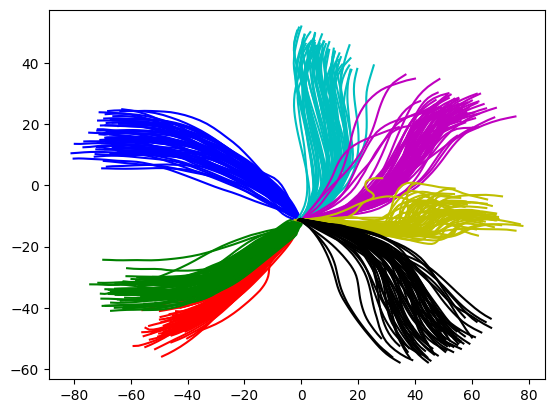

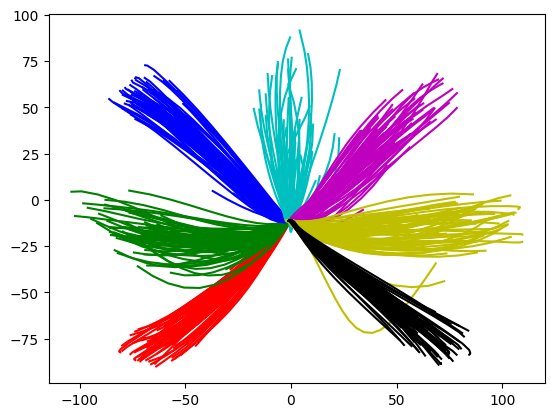

In [23]:
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['marble_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
            
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])

# Run for all days

In [140]:
from sklearn.model_selection import KFold

kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       


In [141]:
## run for lfads factors

kf = KFold(n_splits=5, shuffle=True)


for d in kinematic_data.keys():
    
    K = kinematic_data[d]  
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(list(kinematic_data[d].keys()))):

        # training
        X = []
        Z = []
        y = []
        for tr in train_index:
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['lfads_factors'][:,:-1])
            y.append(K[tr]['condition'])

        X = np.hstack(X)
        Z = np.hstack(Z)
        y = np.hstack(y)

        X = X[:4,:] # they only took first four rows of kinematics
        Z = np.vstack([Z,np.ones(Z.shape[1])])

        # solve linear equations
        out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
        Lw = out[0].T


        # loop over test trials
        alpha = 1
        dt = 20


        for tr in test_index:

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['lfads_factors'][:,:-1] # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['lfads_decoded'] = trial_pred
            
            #x_r2 = sm.OLS(trial_kinematics[0,:].T,sm.add_constant(trial_pred[0,:].T)).fit().rsquared
            #y_r2 = sm.OLS(trial_kinematics[1,:].T,sm.add_constant(trial_pred[1,:].T)).fit().rsquared            
            #kinematic_data[d][tr]['r2_lfads'] = np.mean([x_r2,y_r2]) # r2_score(trial_kinematics[:2,:], trial_pred[:2,:])
            
            kinematic_data[d][tr]['r2_lfads'] = compute_rsquared(trial_kinematics[:2,:], trial_pred[:2,:])            

            kinematic_data[d][tr]['mse_lfads'] = metrics.mean_squared_error(trial_kinematics[:2,:], trial_pred[:2,:])

        


In [142]:
## run for marble embedding

with open('./outputs/distance_matrices_and_embeddings_20ms_sc0.pkl', 'rb') as handle:
    data = pickle.load(handle)

distance_matrices = data[0]
embeddings = data[1]
timepoints = data[2]
labels = data[3]
trial_ids = data[4]
sample_inds = data[5]

for d in range(len(embeddings)): #kinematic_data.keys():
    # use the saved trial ids to match the embeddings to the kinematics

    unique_trial_ids = list(dict.fromkeys(trial_ids[d].tolist()))

    emb = embeddings[d]    
    for t in unique_trial_ids:
        kinematic_data[d][t]['marble_emb'] = emb[trial_ids[d]==t,:]    

    K = kinematic_data[d]
    
    # cross validation
    for i, (train_index, test_index) in enumerate(kf.split(list(kinematic_data[d].keys()))):

        # training
        X = []
        Z = []
        y = []
        for tr in train_index:
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['marble_emb'][:,:].T)
            y.append(K[tr]['condition'])


        X = np.hstack(X)
        Z = np.hstack(Z)
        y = np.hstack(y)

        X = X[:4,:] # they only took first four rows of kinematics
        Z = np.vstack([Z,np.ones(Z.shape[1])])


        out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
        Lw = out[0].T


        # loop over test trials
        alpha = 1
        dt = 20

        # looping over test samples
        for tr in test_index:

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['marble_emb'][:,:].T # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['marble_decoded'] = trial_pred        

            #x_r2 = sm.OLS(trial_kinematics[0,:].T,sm.add_constant(trial_pred[0,:].T)).fit().rsquared
            #y_r2 = sm.OLS(trial_kinematics[1,:].T,sm.add_constant(trial_pred[1,:].T)).fit().rsquared            
            # kinematic_data[d][tr]['r2_marble'] = np.mean([x_r2,y_r2]) #r2_score(trial_kinematics[:2,:], trial_pred[:2,:])
            
            kinematic_data[d][tr]['r2_marble'] = compute_rsquared(trial_kinematics[:2,:], trial_pred[:2,:])            
            kinematic_data[d][tr]['mse_marble'] = metrics.mean_squared_error(trial_kinematics[:2,:], trial_pred[:2,:])
            

In [136]:
def compute_rsquared(X,Y):

    dist = pairwise_distances(X.T, Y.T)
    sse = np.diag(dist).sum()

    dist_m = pairwise_distances(X.T, np.mean(Y,1).reshape(1,-1))
    sst = np.sum(dist_m)

    return (1 - sse/sst)


0.2633427578047929 0.6628327273019732


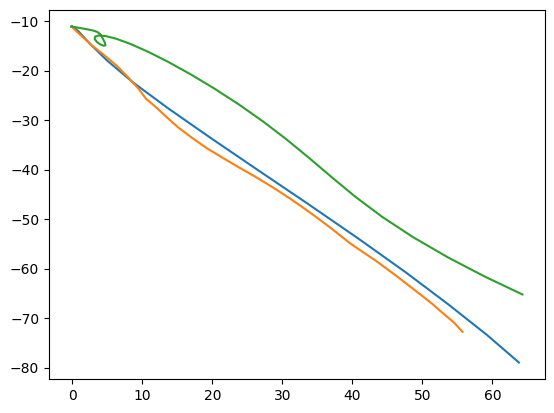

In [154]:
d = 2
tr = 0

plt.plot(kinematic_data[d][tr]['kinematics'][0,:-1],kinematic_data[d][tr]['kinematics'][1,:-1])
plt.plot(kinematic_data[d][tr]['marble_decoded'][0,:],kinematic_data[d][tr]['marble_decoded'][1,:])
plt.plot(kinematic_data[d][tr]['lfads_decoded'][0,:],kinematic_data[d][tr]['lfads_decoded'][1,:])

print(kinematic_data[d][tr]['r2_marble'], kinematic_data[d][tr]['r2_lfads'])

In [156]:
compute_rsquared(kinematic_data[d][tr]['kinematics'][:2,:-1],kinematic_data[d][tr]['marble_decoded'][:2,:])

0.2633427578047929

Text(0.5, 1.0, 'LFADS: r2=0.176')

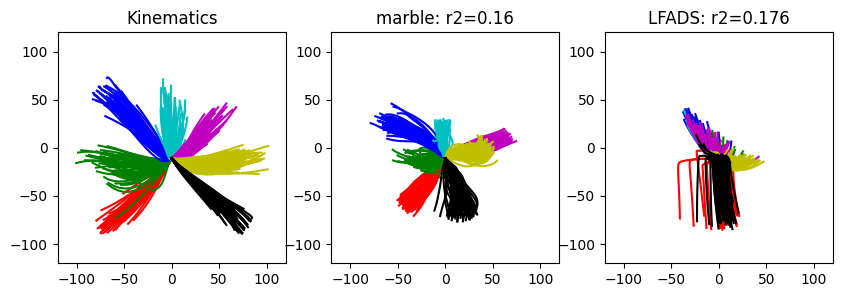

In [151]:
d = 1
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
colors = ['r','g','b','c','m','y','k','w'];

for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            ax[0].plot(meh[0,:],meh[1,:],c=colors[c])
ax[0].set_xlim([-120, 120])
ax[0].set_ylim([-120, 120])
ax[0].set_title('Kinematics')

for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['marble_decoded']
            ax[1].plot(meh[0,:],meh[1,:],c=colors[c])
ax[1].set_xlim([-120, 120])
ax[1].set_ylim([-120, 120])
r2 = np.array([kinematic_data[d][t]['r2_marble'] for t in kinematic_data[d].keys()]).mean().round(3)
ax[1].set_title('marble: r2={}'.format(r2))

            
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['lfads_decoded']
            ax[2].plot(meh[0,:],meh[1,:],c=colors[c])
ax[2].set_xlim([-120, 120])
ax[2].set_ylim([-120, 120])
r2 = np.array([kinematic_data[d][t]['r2_lfads'] for t in kinematic_data[d].keys()]).mean().round(3)
ax[2].set_title('LFADS: r2={}'.format(r2))

### r-squared of decoding

In [61]:
r2_marble = []
r2_lfads = []

for d in range(len(embeddings)):           
    r2_marble.append(np.array([kinematic_data[d][t]['r2_marble'] for t in kinematic_data[d].keys()]).mean())
    r2_lfads.append(np.array([kinematic_data[d][t]['r2_lfads'] for t in kinematic_data[d].keys()]).mean())      

print(np.mean(r2_marble))
print(np.mean(r2_lfads))

0.4751944490262658
0.6877016707520689


### classification of decoding

In [29]:


kinematic_model_acc = []
marble_model_acc = []
lfads_model_acc = []

for d in range(len(embeddings)):           

    # fit classifier to kinematics
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['kinematics'][:2,:-1].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    clf = SVC().fit(X, y)
    kinematic_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on marble decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['marble_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    marble_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on lfads decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['lfads_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    lfads_model_acc.append(clf.score(X, y))

results = pd.DataFrame(data=np.vstack([lfads_model_acc, marble_model_acc]).T,columns=['LFADS','marble'])

results = results.melt()
results.columns = ['model','accuracy']

<AxesSubplot:xlabel='model', ylabel='accuracy'>

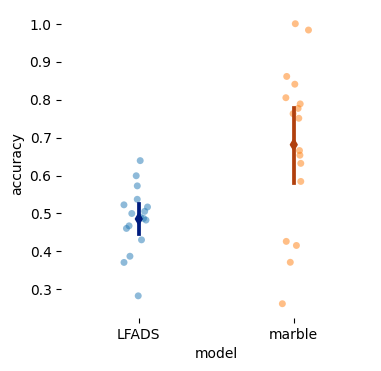

In [30]:
import seaborn as sns

f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)


sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

# Training on subset of days and evaluating on remaining

In [31]:
from sklearn.model_selection import KFold

kinematic_data =  pickle.load(open('../data/kinematics.pkl','rb'))       


In [32]:
## run for lfads factors

kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(list(kinematic_data.keys()))):

    # looping over days in train index
    X = []
    Z = []
    y = []
    for d in train_index:
        K = kinematic_data[d]
        
        for tr in kinematic_data[d].keys():
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['lfads_factors'][:,:-1])
            y.append(K[tr]['condition'])
            
        
    X = np.hstack(X)
    Z = np.hstack(Z)
    y = np.hstack(y)

    X = X[:4,:] # they only took first four rows of kinematics
    Z = np.vstack([Z,np.ones(Z.shape[1])])

    # solve linear equations
    out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
    Lw = out[0].T

    # loop over test trials
    alpha = 1
    dt = 20

    # looping over days in test index
    for d in test_index:
        K = kinematic_data[d]


        for tr in kinematic_data[d].keys():

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['lfads_factors'][:,:-1] # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['lfads_decoded'] = trial_pred
            kinematic_data[d][tr]['r2_lfads'] = r2_score(trial_kinematics[:2,:], trial_pred[:2,:])
            kinematic_data[d][tr]['mse_lfads'] = metrics.mean_squared_error(trial_kinematics[:2,:], trial_pred[:2,:])

        


In [33]:
## run for lfads factors

kf = KFold(n_splits=5, shuffle=True)

for d in range(len(embeddings)): #kinematic_data.keys():
    # use the saved trial ids to match the embeddings to the kinematics
    unique_trial_ids = list(dict.fromkeys(trial_ids[d].tolist()))

    emb = embeddings[d]    
    for t in unique_trial_ids:
        kinematic_data[d][t]['marble_emb'] = emb[trial_ids[d]==t,:]    


for i, (train_index, test_index) in enumerate(kf.split(range(len(embeddings)))):

    # looping over days in train index
    X = []
    Z = []
    y = []
    for d in train_index:
        K = kinematic_data[d]
        
        for tr in kinematic_data[d].keys():
            X.append(K[tr]['kinematics'][:,:-1])
            Z.append(K[tr]['marble_emb'][:,:].T)
            y.append(K[tr]['condition'])
            
        
    X = np.hstack(X)
    Z = np.hstack(Z)
    y = np.hstack(y)

    X = X[:4,:] # they only took first four rows of kinematics
    Z = np.vstack([Z,np.ones(Z.shape[1])])

    # solve linear equations
    out  = np.linalg.lstsq(Z.T, X.T, rcond=None)
    Lw = out[0].T

    # loop over test trials
    alpha = 1
    dt = 20

    # looping over days in test index
    for d in test_index:
        K = kinematic_data[d]


        for tr in kinematic_data[d].keys():

            #trial_emb = emb[:,trial_indexes==t] # get trial embedding
            trial_emb = K[tr]['marble_emb'][:,:].T # get trial embedding
            trial_kinematics = K[tr]['kinematics'][:,:-1] # get kinematics associated with trial


            trial_emb = np.vstack([trial_emb,np.ones(trial_emb.shape[1])])


            # first time point of embedding
            neural = trial_emb[:,0]

            # empty array for decoding predictions
            trial_pred = np.empty([trial_kinematics.shape[0]+1,trial_kinematics.shape[1]])
            trial_pred[:] = np.nan

            trial_pred[:2,0] = trial_kinematics[:2,0]

            # predict velocity 
            z  = np.matmul(Lw,neural); # decode
            trial_pred[[2,3],0] = z[[2,3]]
            trial_pred[4,0] = 1


            # loop over each time point in trial
            for nt in range(1,trial_kinematics.shape[1]):

                neural = trial_emb[:,nt] # next point of embedding
                z  = np.matmul(Lw,neural); # decode

                trial_pred[:2,nt] = (1-alpha)*z[:2] + alpha *(trial_pred[:2,nt-1] + z[[2,3]]*dt/1000);

                trial_pred[[2,3],nt] = z[[2,3]]
                trial_pred[4,nt] = 1

            kinematic_data[d][tr]['marble_decoded'] = trial_pred
            kinematic_data[d][tr]['r2_marble'] = r2_score(trial_kinematics[:2,:], trial_pred[:2,:])
            kinematic_data[d][tr]['mse_marble'] = metrics.mean_squared_error(trial_kinematics[:2,:], trial_pred[:2,:])

        


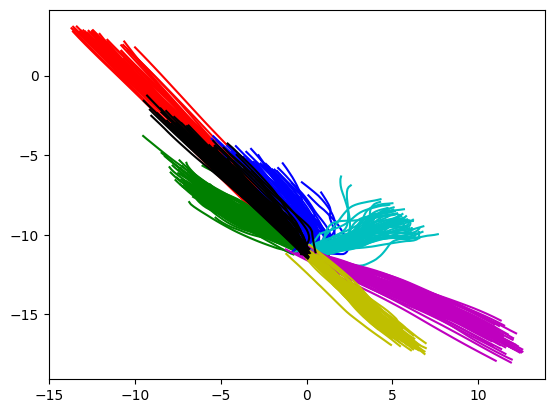

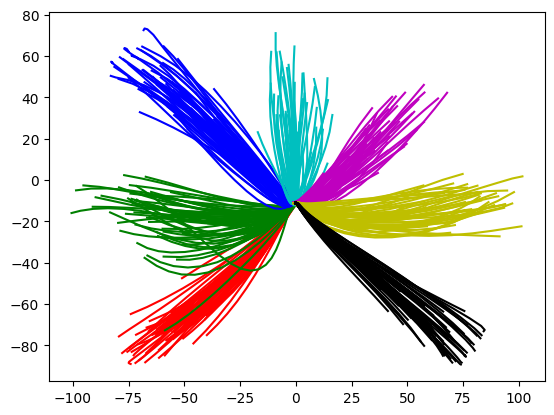

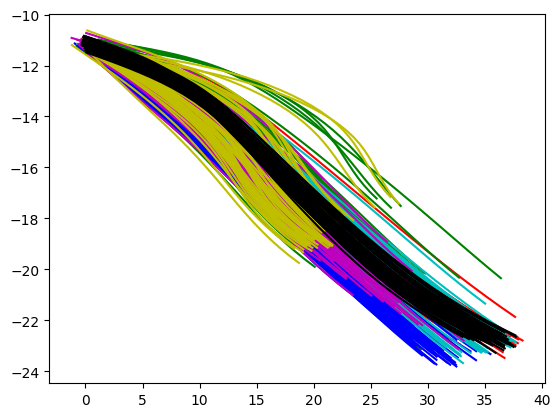

In [34]:
d = 20
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['marble_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
            
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['kinematics']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])
            
plt.figure()
colors = ['r','g','b','c','m','y','k','w'];
for c,cond in enumerate(conditions):   
    for t in kinematic_data[d].keys():
        if kinematic_data[d][t]['condition']==cond:
            meh = kinematic_data[d][t]['lfads_decoded']
            plt.plot(meh[0,:],meh[1,:],c=colors[c])

In [35]:
r2_marble = []
r2_lfads = []

for d in range(len(embeddings)):           
    r2_marble.append(np.array([kinematic_data[d][t]['r2_marble'] for t in kinematic_data[d].keys()]).mean())
    r2_lfads.append(np.array([kinematic_data[d][t]['r2_lfads'] for t in kinematic_data[d].keys()]).mean())      

print(np.mean(r2_marble))
print(np.mean(r2_lfads))

-33155.84010636425
-40721.71668526375


In [36]:

from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

kinematic_model_acc = []
marble_model_acc = []
lfads_model_acc = []

for d in range(len(embeddings)):           

    # fit classifier to kinematics
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['kinematics'][:2,:-1].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    clf = SVC().fit(X, y)
    kinematic_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on marble decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['marble_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    marble_model_acc.append(clf.score(X, y))
    
    
    # evaluate model on lfads decoded
    samples = []; labels = [];
    for c,cond in enumerate(conditions):   
        for t in kinematic_data[d].keys():
            if kinematic_data[d][t]['condition']==cond:
                sample = kinematic_data[d][t]['lfads_decoded'][:2,:].flatten()
                samples.append(sample)
                labels.append(c)

    X = np.vstack(samples)
    y = np.array(labels)
    lfads_model_acc.append(clf.score(X, y))

results = pd.DataFrame(data=np.vstack([lfads_model_acc, marble_model_acc]).T,columns=['LFADS','marble'])

results = results.melt()
results.columns = ['model','accuracy']

<AxesSubplot:xlabel='model', ylabel='accuracy'>

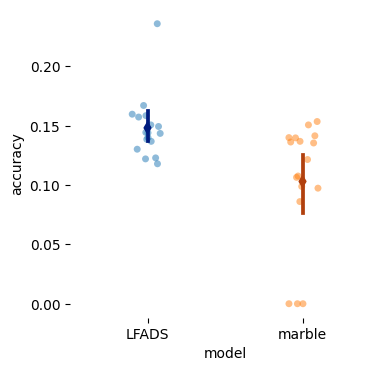

In [37]:
import seaborn as sns

f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)

sns.stripplot(
    data=results, x="model", y="accuracy",
    dodge=True, alpha=.5, zorder=1,
)


sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)